In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from xgboost import XGBRegressor
import plotly.express as px
from pathlib import Path
import pandas as pd
import numpy as np
import holidays
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')

In [2]:
def upload_data():
    data_path = str(Path.cwd().parent) + "\\Data\\EPC\\Power Consumption Data.csv"
    
    df = pd.read_csv(data_path)
    
    df = df[df["real_consumption"] > 0]
    df = df[df['real_consumption'] <= df['real_consumption'].mean() + 4 * df['real_consumption'].std()]
    
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values(by='time',ascending=True)
    
    return df

def data_metrics(data, real, predicted):

    y_true = data[real]
    y_pred = data[predicted]

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)


    # MAE (Mean Absolute Error):
    # Lower values are better; good MAE depends on the scale of 'real_consumption'.
    # As a rule of thumb, MAE should be significantly smaller than the mean of the target variable.
    # Lower is better. Ideally, MAE should be much less than the average value of y_true.
    print(f"MAE: {mae:.4f}")

    # MSE (Mean Squared Error):
    # Similar to MAE but penalizes large errors more heavily. A smaller MSE is better.
    # Compare MSE to the variance of 'real_consumption' for context.
    # Lower is better. MSE should ideally be close to zero relative to the variance of y_true.
    print(f"MSE: {mse:.4f}")



    # RMSE (Root Mean Squared Error):
    # RMSE is the square root of MSE and is in the same units as 'real_consumption'.
    # A good RMSE is often close to the standard deviation of 'real_consumption'.
    # Lower is better. RMSE should be comparable to or less than the standard deviation of y_true."
    print(f"RMSE: {rmse:.4f}")



    # R² (Coefficient of Determination):
    # R² measures how well the predictions explain the variability of the data.
    # Values close to 1.0 are excellent, indicating the model explains most of the variance.
    # Negative values indicate poor fit.
    # Closer to 1.0 is better. Values > 0.7 are generally good; < 0.5 indicates underfitting.
    print(f"R²: {r2:.4f}")

def feature_engineering(data):

    # Extracting basic time-based features
    data['hour'] = data['time'].dt.hour  # Hour of the day
    data['minute'] = data['time'].dt.minute  # Minute
    data['day_of_week'] = data['time'].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)
    data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)  # Weekend flag
    data['day_of_month'] = data['time'].dt.day
    data['week_of_year'] = data['time'].dt.isocalendar().week
    data['month'] = data['time'].dt.month
    data['quarter'] = data['time'].dt.quarter
    data['year'] = data['time'].dt.year


    # Generate lag features for temporal dependency modeling
    for lag in range(1, 5):  # Create lag features for the past 4 time steps
        data[f'lag_{lag}'] = data['real_consumption'].shift(lag)


    # Generate exponential moving averages
    for span in [3, 5]:  # Spans of size 3, 5, and 7
        data[f'ema_{span}'] = data['real_consumption'].ewm(span=span, adjust=False).mean()

    # Rolling average over a longer period (e.g., weekly and monthly moving averages)
    data['weekly_avg'] = data['real_consumption'].rolling(window=7*24*20, min_periods=1).mean()  # Weekly moving avg
    data['monthly_avg'] = data['real_consumption'].rolling(window=30*24*20, min_periods=1).mean()  # Monthly moving avg


# Percentage change in real consumption
    data['pct_change'] = data['real_consumption'].pct_change()

    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)  # Cyclic hour feature (sine)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)  # Cyclic hour feature (cosine)
 
    data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)
    
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    
    data['week_of_year_sin'] = np.sin(2 * np.pi * data['week_of_year'] / 52)
    data['week_of_year_cos'] = np.cos(2 * np.pi * data['week_of_year'] / 52)




    # Get Georgia holidays for all years in the dataset
    georgia_holidays = holidays.Georgia(years=range(data["year"].min(), data["year"].max() + 1))

    data["date"] = data["time"].dt.date
    
    # Create holiday feature (1 if it's a holiday, 0 otherwise)
    data['is_holiday'] = data["date"].map(lambda x: 1 if x in georgia_holidays else 0)
    
    # Add features for the day before and after a holiday
    data['is_day_before_holiday'] = data["date"].map(lambda x: 1 if (x - pd.Timedelta(days=1)) in georgia_holidays else 0)
    data['is_day_after_holiday'] = data["date"].map(lambda x: 1 if (x + pd.Timedelta(days=1)) in georgia_holidays else 0)



    return  data



In [3]:
df = upload_data()

data_metrics(data=df, real="real_consumption", predicted="predicted_consumption")

df = feature_engineering(df)[["time","real_consumption","predicted_consumption"]]


MAE: 56.7256
MSE: 5824.3342
RMSE: 76.3173
R²: 0.9176


In [4]:
scaler = MinMaxScaler()
df["real_consumption"] = scaler.fit_transform(df["real_consumption"].values.reshape(-1, 1))
df["predicted_consumption"] = scaler.fit_transform(df["predicted_consumption"].values.reshape(-1, 1))

In [5]:
SEQ_LEN = 120  # Use past 12 hours (240 steps, 3-minute intervals)
PRED_LEN = 120  # Predict next 12 hours

def create_sequences(data, seq_len, pred_len):
    X, y = [], []
    for i in range(len(data) - seq_len - pred_len):
        X.append(data[i : i + seq_len])
        y.append(data[i + seq_len : i + seq_len + pred_len])
    return np.array(X), np.array(y)

# Prepare sequences
X, y = create_sequences(df["real_consumption"].values, SEQ_LEN, PRED_LEN)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

In [6]:
# Define split percentages
train_ratio = 0.65  # 65% training
test_ratio = 0.15   # 15% testing
future_ratio = 0.20 # 20% future forecasting

# Compute dataset sizes
train_size = int(train_ratio * len(X))
test_size = int(test_ratio * len(X))

# Split data
X_train, X_test, X_future = X_tensor[:train_size], X_tensor[train_size:train_size+test_size], X_tensor[train_size+test_size:]
y_train, y_test, y_future = y_tensor[:train_size], y_tensor[train_size:train_size+test_size], y_tensor[train_size+test_size:]

# Create DataLoaders for training and testing
BATCH_SIZE = 128

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)



In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Predict only the last step

INPUT_SIZE = 1
HIDDEN_SIZE = 16
NUM_LAYERS = 1
OUTPUT_SIZE = PRED_LEN  # 240 predictions

model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [8]:
EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


LSTMModel(
  (lstm): LSTM(1, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=120, bias=True)
)

In [9]:
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch.unsqueeze(-1))
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch.unsqueeze(-1))
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(test_loader):.4f}")

torch.save(model.state_dict(), "lstm_energy_forecast.pth")


Epoch 1/10, Train Loss: 0.0109, Val Loss: 0.0074
Epoch 2/10, Train Loss: 0.0059, Val Loss: 0.0068
Epoch 3/10, Train Loss: 0.0054, Val Loss: 0.0060
Epoch 4/10, Train Loss: 0.0051, Val Loss: 0.0063
Epoch 5/10, Train Loss: 0.0048, Val Loss: 0.0060
Epoch 6/10, Train Loss: 0.0046, Val Loss: 0.0057
Epoch 7/10, Train Loss: 0.0043, Val Loss: 0.0052
Epoch 8/10, Train Loss: 0.0040, Val Loss: 0.0050
Epoch 9/10, Train Loss: 0.0037, Val Loss: 0.0045
Epoch 10/10, Train Loss: 0.0036, Val Loss: 0.0038


In [10]:
model.eval()
X_sample, y_sample = next(iter(test_loader))
X_sample, y_sample = X_sample.to(device), y_sample.to(device)

with torch.no_grad():
    predictions = model(X_sample.unsqueeze(-1)).cpu().numpy()


In [11]:
y_sample = scaler.inverse_transform(y_sample.cpu().numpy())
predictions = scaler.inverse_transform(predictions)


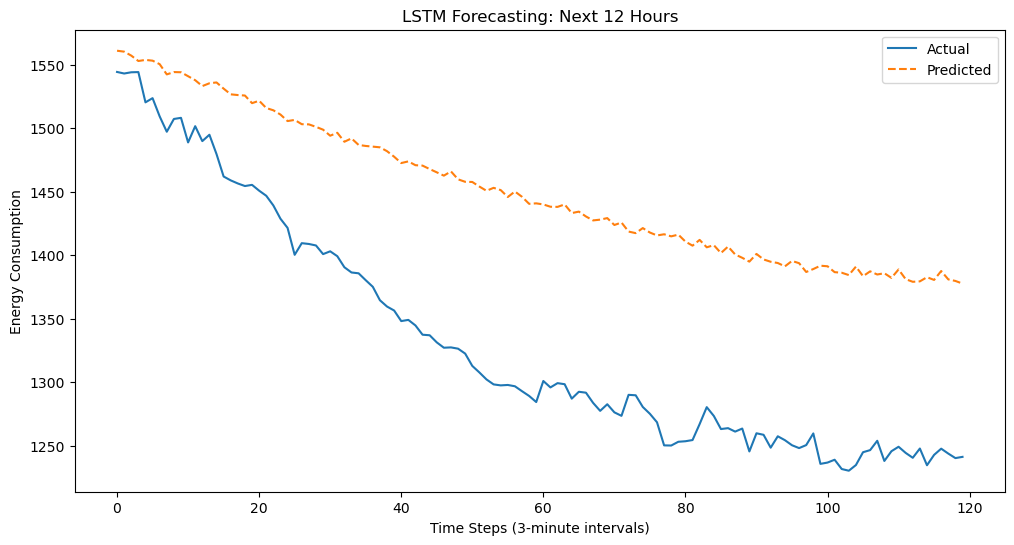

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(y_sample[0], label="Actual")
plt.plot(predictions[0], label="Predicted", linestyle="dashed")
plt.xlabel("Time Steps (3-minute intervals)")
plt.ylabel("Energy Consumption")
plt.legend()
plt.title("LSTM Forecasting: Next 12 Hours")
plt.show()


In [18]:
data_metrics(data=reuslts_df, real="real_consumption", predicted="predicted_consumption_new")

data_metrics(data=reuslts_df, real="real_consumption", predicted="predicted_consumption")

MAE: 28.3496
MSE: 1449.8315
RMSE: 38.0767
R²: 0.9768
MAE: 83.3045
MSE: 8800.2009
RMSE: 93.8094
R²: 0.8594


In [19]:
0.9768

0.9768